In [1]:
import time
import math
import copy
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm
import IPython.display
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
# Notebook run settings.
skip_training = True

deterministic = True
seed = 12345

model_fname = "quadmodel.pt"

In [3]:
# Fix seeds.

# Reset.
if "CUBLAS_WORKSPACE_CONFIG" in os.environ:
    del os.environ["CUBLAS_WORKSPACE_CONFIG"]

# Set determinism.
if deterministic:
    np.random.seed(seed)
    # https://pytorch.org/docs/stable/notes/randomness.html
    torch.manual_seed(seed)
    torch.set_deterministic(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    if float(torch.version.cuda) >= 10.2:
        # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Problem setup:
blims=[-1000, 1000]
clims=[-1000, 1000]

# Data breakdown:
N_train_val_test = (10_000, 5_000, 10_000)

# Model architecture:
hs = (128, 2048, 2048, 128)  # (1024, 1024)

# Training main params:
epochs = 20_000
erstop_patience = int(epochs / 10)
batch_size = 512

# Learning rate:
lr = 0.01
lrd_step = 50
lrd_factor = 0.99
lr_min = 0.0001

In [6]:
def generate(N, blims, clims):
    
    N_buff = N * 2
    
    a = np.ones(N_buff)
    b = np.random.uniform(blims[0], blims[1], N_buff)
    c = np.random.uniform(clims[0], clims[1], N_buff)

    discr = b**2 - 4* a * c

    discr = discr >= 0
    if discr.sum() < N:
        raise RuntimeError(f"Could't generate {N} many samples, could only generate {discr.sum()}.")

    a, b, c = a[discr][:N], b[discr][:N], c[discr][:N]

    x1 = (-b + np.sqrt(b**2 - 4* a * c))/(2*a)
    x2 = (-b - np.sqrt(b**2 - 4* a * c))/(2*a)

    return b, c, x1, x2

In [7]:
# Generate data and set up data loaders.

num_workers = 2

datasets = []
dataloaders = []
raw_data = []

for N_set in N_train_val_test:
    b, c, x1, x2 = generate(N_set, blims, clims)
    # print("b, c, x1, x2"), display(b, c, x1, x2)
    Y = np.concatenate([[b], [c]], axis=0).T
    X = np.concatenate([[x1], [x2]], axis=0).T
    # print("X, Y"), display(X, Y)
    tensor_X = torch.Tensor(X).to(device)
    tensor_Y = torch.Tensor(Y).to(device)
    raw_data.append([tensor_X, tensor_Y])
    quad_dataset = TensorDataset(tensor_X, tensor_Y)
    quad_dataloader = DataLoader(quad_dataset, batch_size, num_workers)
    datasets.append(quad_dataset)
    dataloaders.append(quad_dataloader)

train_loader = dataloaders[0]
val_loader = dataloaders[1]
test_loader = dataloaders[2]

train_total = math.ceil(N_train_val_test[0]/batch_size)
val_total = math.ceil(N_train_val_test[1]/batch_size)
test_total = math.ceil(N_train_val_test[2]/batch_size)

print(len(datasets[0]), len(datasets[1]), len(datasets[2]))

10000 5000 10000


In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, hs[0])
        self.fc2 = nn.Linear(hs[0], hs[1])
        if len(hs) > 2:
            self.fc3 = nn.Linear(hs[1], hs[2])
            if len(hs) > 3:
                self.fc4 = nn.Linear(hs[2], hs[3])
                self.out = nn.Linear(hs[3], 2)
            else:
                self.out = nn.Linear(hs[2], 2)
        else:
            self.out = nn.Linear(hs[1], 2)
        
        self.af1 = nn.ReLU()
        self.af2 = nn.ReLU()
        if len(hs) > 2:
            self.af3 = nn.ReLU()
            if len(hs) > 3:
                self.af4 = nn.ReLU()

    def forward(self, x):
        x = self.af1(self.fc1(x))
        x = self.af2(self.fc2(x))
        if len(hs) > 2:
            x = self.af3(self.fc3(x))
            if len(hs) > 3:
                x = self.af4(self.fc4(x))
        x = self.out(x)
        return x

mlp = MLP().to(device)

In [9]:
opt = torch.optim.Adam(mlp.parameters(), lr)

In [10]:
mse = torch.nn.MSELoss(reduction="mean")

In [11]:
%matplotlib inline

if not skip_training:

    train_losses, val_losses = np.full([epochs], np.nan), np.full([epochs], np.nan)
    x_axis = list(range(1, epochs + 1))

    erstop_best = float("inf")
    erstop_arr = np.full([erstop_patience], float("inf"))
    best_epoch = 0
    best_state_dict = {"epoch_id": 0, "training_loss": 0, "val_loss": 0, "state_dict": None}

    for e in range(0, epochs):

        # TRAINING:
        mlp.train()
        losses = np.zeros([train_total])
        for i, (X, Y) in enumerate(train_loader):
            opt.zero_grad()
            Y_pred = mlp(X)
            loss = mse(Y_pred, Y)
            losses[i] = loss.detach().cpu().item()
            loss.backward()
            opt.step()
            # print(f"Iteration {i+1}: loss={loss:3f}")
        epoch_loss = losses.mean()

        # VALIDATION:
        mlp.eval()
        losses = np.zeros([val_total])
        with torch.no_grad():
            for i, (X, Y) in enumerate(val_loader):
                Y_pred = mlp(X)
                loss = mse(Y_pred, Y)
                losses[i] = loss.detach().cpu().item()
                # print(f"Iteration {i+1}: loss={loss:3f}")
        epoch_val_mse = losses.mean()

        train_losses[e] = epoch_loss
        val_losses[e] = epoch_val_mse

        plt.plot(x_axis, train_losses, label = "training loss")
        plt.plot(x_axis, val_losses, label = "validation loss")
        plt.title("Training Tracker")
        plt.legend()
        x_max = min( max( int(e * 1.2), min(500,epochs) ), epochs )
        plt.xlim(1, x_max)
        plt.ylim(0, np.percentile(train_losses[:e+1], 90))
        IPython.display.clear_output(wait=True)
        plt.show()
        
        print(f"Epoch {e+1}:\t" + f"train_loss = {epoch_loss:.5f}\t" + f"val_loss = {epoch_val_mse:.5f}\t" + f"v/t = {(epoch_val_mse/epoch_loss):.5f}\t" + f"lr = {lr:.8f}")

        # EARLY STOPPING:
        past_losses = val_losses[:e+1][-erstop_patience:]
        erstop_arr[:len(past_losses)] = past_losses
        min_in_arr = erstop_arr.min()
        erstop_best = min(erstop_best, min_in_arr)
        best_epoch = max(0, e - erstop_patience)
        if epoch_val_mse == erstop_best:
            best_state_dict["epoch_id"] = e
            best_state_dict["training_loss"] = epoch_loss
            best_state_dict["val_loss"] = epoch_val_mse
            best_state_dict["state_dict"] = mlp.state_dict()
        if erstop_best != min_in_arr:
            print(f"Early stopping engaged! Best epoch: {best_epoch}")
            break
        # print("past_losses", past_losses)
        # print("erstop_arr", erstop_arr)
        # print("erstop_best", erstop_best)

        # lr decay:
        if (e % lrd_step == 0) and (e > 0):
            lr = lrd_factor * lr
            if lr < lr_min:
                lr = lr_min
            for g in opt.param_groups:
                g['lr'] = lr
            print(f"LR decay step! lr = {lr} now.")

    # print(best_state_dict)
    print("Best epoch info:")
    print({k: v for k, v in best_state_dict.items() if k != "state_dict"})
    mlp.load_state_dict(best_state_dict["state_dict"])

In [35]:
# Save / load model.
if not os.path.exists("./models"):
    os.makedirs("./models")

model_path = os.path.abspath(os.path.join("./models", model_fname))

if not skip_training:
    torch.save(mlp.state_dict(), model_path)
else:
    mlp.load_state_dict(torch.load(model_path))

In [13]:
# EVALUATE.
mlp.eval()
losses = np.zeros([test_total])
with torch.no_grad():
    for i, (X, Y) in enumerate(test_loader):
        Y_pred = mlp(X)
        loss = mse(Y_pred, Y)
        losses[i] = loss.detach().cpu().item()
        # print(f"Iteration {i+1}: loss={loss:3f}")
test_mse = losses.mean()
test_rmse = np.sqrt(test_mse)

print(f"Test MSE: {test_mse:.5f} (RMSE={test_rmse:.5f})")

Test MSE: 2.24663 (RMSE=1.49888)


In [14]:
def predict(X):
    # No batching here for simplicity.
    return mlp(X)

In [15]:
def split_data(X, Y, Y_pred):
    X, Y, Y_pred = X.detach().cpu().clone(), Y.detach().cpu().clone(), Y_pred.detach().cpu().clone()
    return {"x1": X[:, 0], "x2": X[:, 1], "b": Y[:, 0], "c": Y[:, 1], "b_pred": Y_pred[:, 0], "c_pred": Y_pred[:, 1]}

def put_into_df(X, Y, Y_pred):
    dict_ = split_data(X, Y, Y_pred)
    return pd.DataFrame(dict_, index=range(0, X.shape[0]))

In [16]:
tensor_X, tensor_Y = raw_data[2]  # Test set
tensor_Y_pred = predict(tensor_X)
df = put_into_df(tensor_X, tensor_Y, tensor_Y_pred)
display(df)

,x1,x2,b,c,b_pred,c_pred
0,207.475632,2.630125,-210.105759,545.686768,-210.353775,549.428528
1,741.754700,-0.901314,-740.853394,-668.554016,-740.520691,-668.357300
2,518.417236,-0.541292,-517.875916,-280.615295,-517.955139,-279.960541
3,1.639174,-457.215179,455.576019,-749.455200,455.450684,-752.127380
4,-1.058729,-934.551392,935.610107,989.436707,935.213928,989.465149
...,...,...,...,...,...,...
9995,-0.714876,-249.871078,250.585953,178.626816,250.518494,178.550232
9996,1.488073,-566.028076,564.540039,-842.291138,564.500427,-841.299194
9997,-1.097768,-812.328308,813.426086,891.748352,813.063171,891.701538
9998,-0.579797,-752.334656,752.914429,436.201202,752.868408,435.431244



b, c for data generated within the training limits: blims=[-1000, 1000], clims=[-1000, 1000]



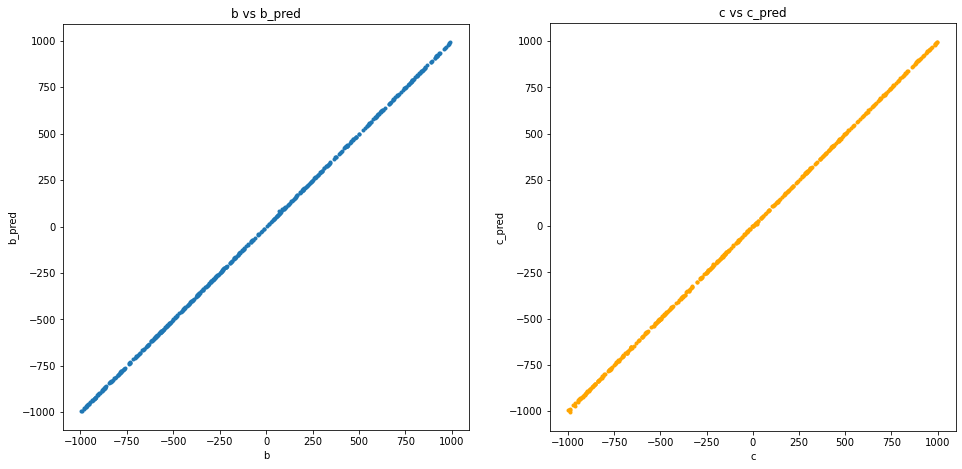

In [32]:
# Plot actual vs predicted.
def act_vs_pred_plot(df, sample_frac, sample_seed, blim=None, clim=None):
    df_ = df.sample(frac=sample_frac, random_state=sample_seed)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    plt.axes(axs[0])

    plt.plot(df_["b"], df_["b_pred"], ".")
    plt.xlabel("b")
    plt.ylabel("b_pred")
    plt.title("b vs b_pred")

    plt.axes(axs[1])

    plt.plot(df_["c"], df_["c_pred"], ".", color="orange")
    plt.xlabel("c")
    plt.ylabel("c_pred")
    plt.title("c vs c_pred")
    
    axs[0].set_aspect(1)
    axs[1].set_aspect(1)
    
    if blim is not None:
        axs[0].set_xlim(blim)
        axs[0].set_ylim(blim)
    if clim is not None:
        axs[1].set_xlim(clim)
        axs[1].set_ylim(clim)

print("\n" + "b, c for data generated within the training limits: blims=[-1000, 1000], clims=[-1000, 1000]" + "\n")
act_vs_pred_plot(df, sample_frac=0.05, sample_seed=123)


b, c for data generated wihin and outside the training limits: blims=[-4000, 4000], clims=[-4000, 4000]



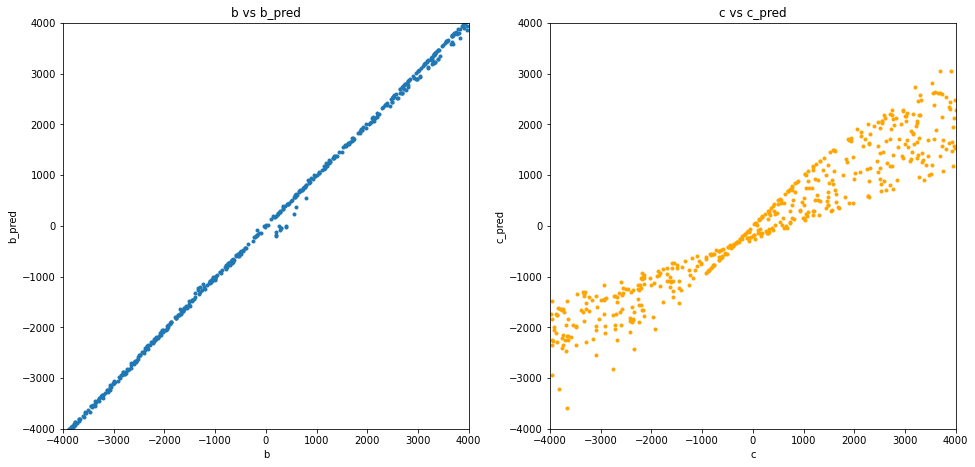

In [33]:
# Try values outside the training range.
blim = [-4_000, 4_000]
clim = [-4_000, 4_000]
b, c, x1, x2 = generate(N=10_000, blims=blim, clims=clim)

Y_outside = np.concatenate([[b], [c]], axis=0).T
X_outside = np.concatenate([[x1], [x2]], axis=0).T

tensor_X_outside = torch.Tensor(X_outside).to(device)
tensor_Y_outside = torch.Tensor(Y_outside).to(device)
tensor_Y_pred_outside = predict(tensor_X_outside)

df_outside = put_into_df(tensor_X_outside, tensor_Y_outside, tensor_Y_pred_outside)

print("\n" + "b, c for data generated wihin and outside the training limits: blims=[-4000, 4000], clims=[-4000, 4000]" + "\n")
act_vs_pred_plot(df_outside, sample_frac=0.05, sample_seed=123, blim=blim, clim=clim)